In [1]:
import psyplot.project as psy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

base_path = '/work/bd1179/b309170/esmvaltool_output/from_swiftbrowser'

INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


#### Comparison of ICON-ML with ICON-A, ICON-ML+4K with ICON-A+4K; where are the biggest differences?

In [2]:
paths = {}
paths['icon_nat'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov1_long'
paths['icon_nat_4K'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov1_long_sst+4k'
paths['icon_ml'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long'
paths['icon_ml_4K'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long_sst+4k'

keys = list(paths.keys())

In [4]:
# Start with 2D data
data_2d = {}
for key in keys:
    # All 2D data
    data_2d[key] = xr.open_mfdataset(paths[key] + '/*atm_2d_ml*.nc')

# We are interested in the difference of ICON-ML and ICON
data_2d['icon_diff'] = data_2d['icon_ml'] - data_2d['icon_nat']
data_2d['icon_4K_diff'] = data_2d['icon_ml_4K'] - data_2d['icon_nat_4K']

In [5]:
# Exclude time steps
DS_excluded = data_2d['icon_diff'].isel(time=slice(1, None))  # Removes the first time step
DS_excluded_4K = data_2d['icon_4K_diff'].isel(time=slice(121, None))  # Take the last 10 YEARS

rel_diffs = {}
rel_diffs_4K = {}

for var_name in DS_excluded.data_vars:
    if var_name in ['clon_bnds', 'clat_bnds']:
        continue

    # Compute the temporal mean for each variable (over the 'time' dimension)
    temporal_mean = getattr(DS_excluded, var_name).mean(dim='time')
    temporal_mean_4K = getattr(DS_excluded_4K, var_name).mean(dim='time')

    # Compute the overall mean for each variable
    overall_mean = getattr(data_2d['icon_nat'].isel(time=slice(1, None)), var_name).mean()
    overall_mean_4K = getattr(data_2d['icon_nat_4K'].isel(time=slice(121, None)), var_name).mean()

    # Compute the relative measure (temporal mean divided by overall mean)
    rel_diffs[var_name] = temporal_mean / overall_mean
    rel_diffs_4K[var_name] = temporal_mean_4K / overall_mean_4K

In [7]:
# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

##### ICON-ML vs ICON-A 2D variables

<Figure size 2000x2500 with 0 Axes>

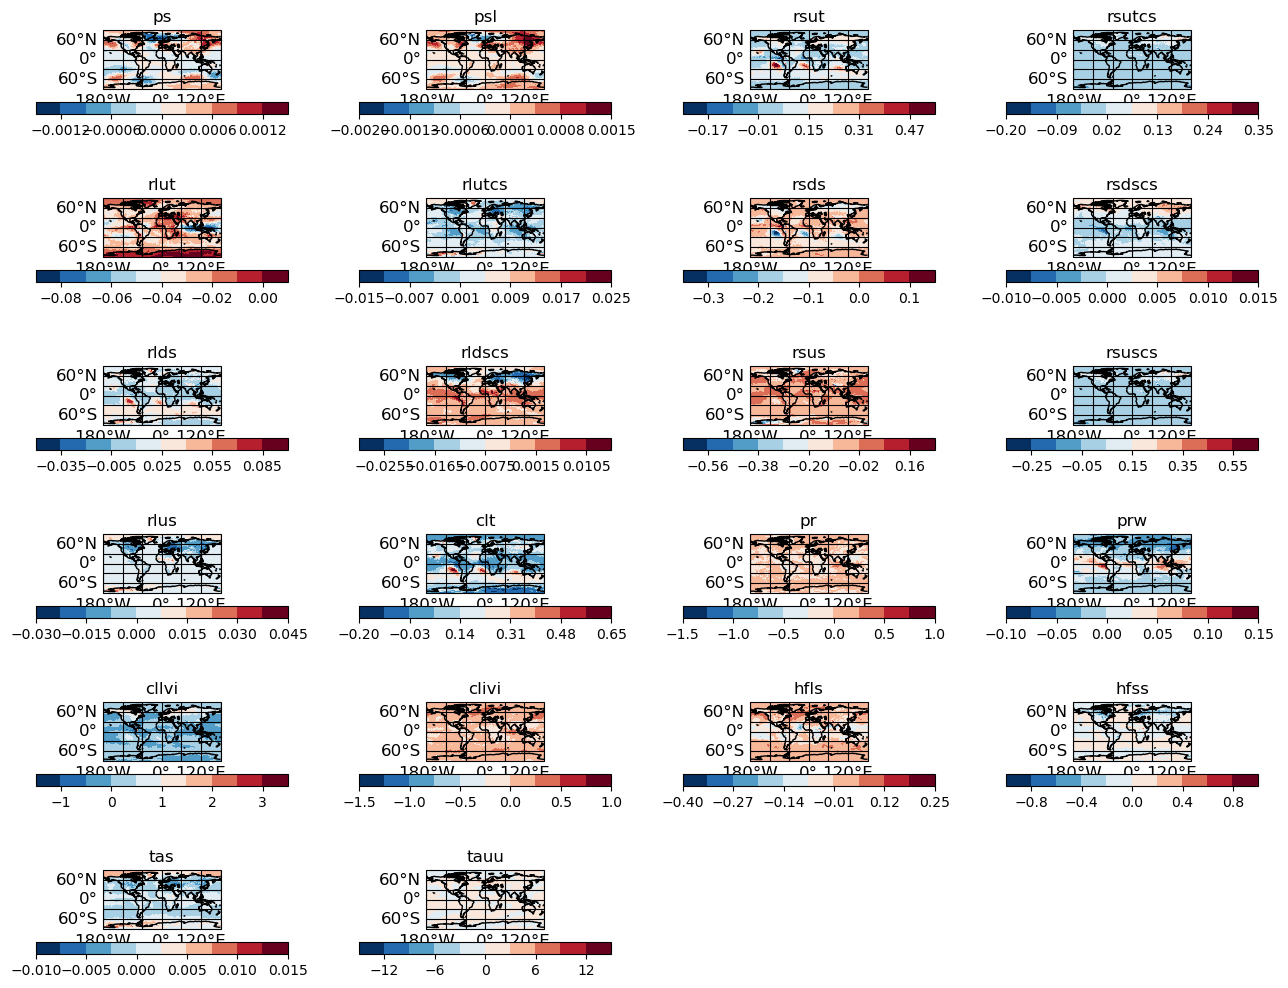

In [83]:
# Variables to loop through
all_vars = list(rel_diffs.keys())
n_plots = len(all_vars)

plt.figure(figsize=(20, 25))

# Define subplots 
ax = list(psy.multiple_subplots(rows=n_plots//4 + 1, cols=4, n=n_plots-1, for_maps=True))

plot_ind = 0
for var in all_vars:
    if var == 'rsdt': # Is all 0
        continue
    file_template.clt.values[0] = rel_diffs[var].values
    psy.plot.mapplot(file_template, name='clt', title=var, time = [0], ax = ax[plot_ind], cmap='RdBu_r')
    plot_ind = plot_ind + 1

plt.subplots_adjust(hspace=1, wspace=0.2)

Focusing in on the largest relative differences

<Figure size 1000x1000 with 0 Axes>

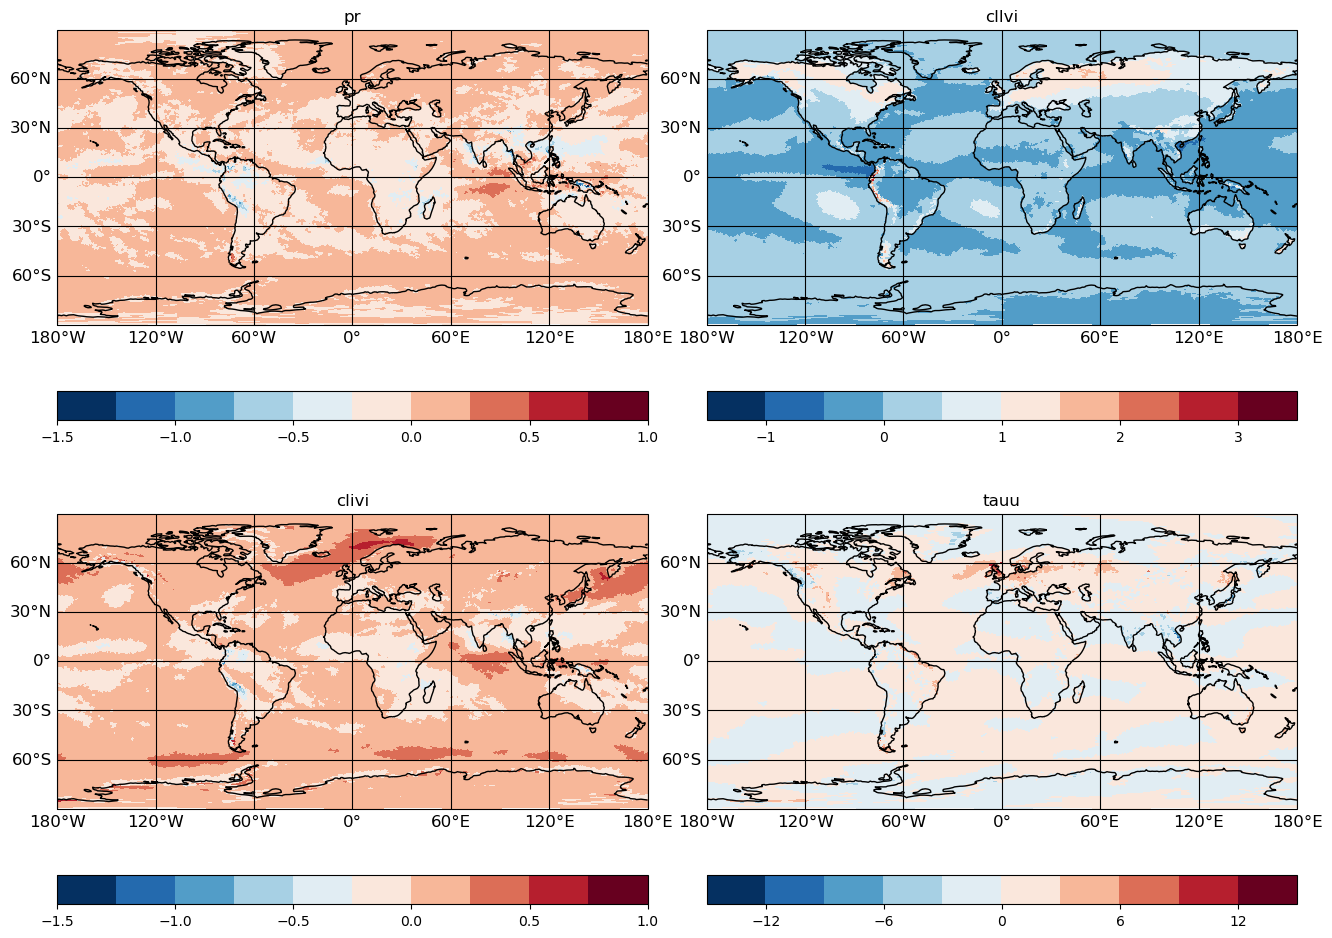

In [8]:
# Variables to loop through
all_vars = list(rel_diffs.keys())
n_plots = len(all_vars)

plt.figure(figsize=(10, 10))

# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=4, for_maps=True))

plot_ind = 0
for var in ['pr', 'cllvi', 'clivi', 'tauu']:
    if var == 'rsdt': # Is all 0
        continue
    file_template.clt.values[0] = rel_diffs[var].values
    psy.plot.mapplot(file_template, name='clt', title=var, time = [0], ax = ax[plot_ind], cmap='RdBu_r')
    plot_ind = plot_ind + 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)

##### ICON-ML+4K vs ICON-A+4K 2D variables

<Figure size 2000x2500 with 0 Axes>

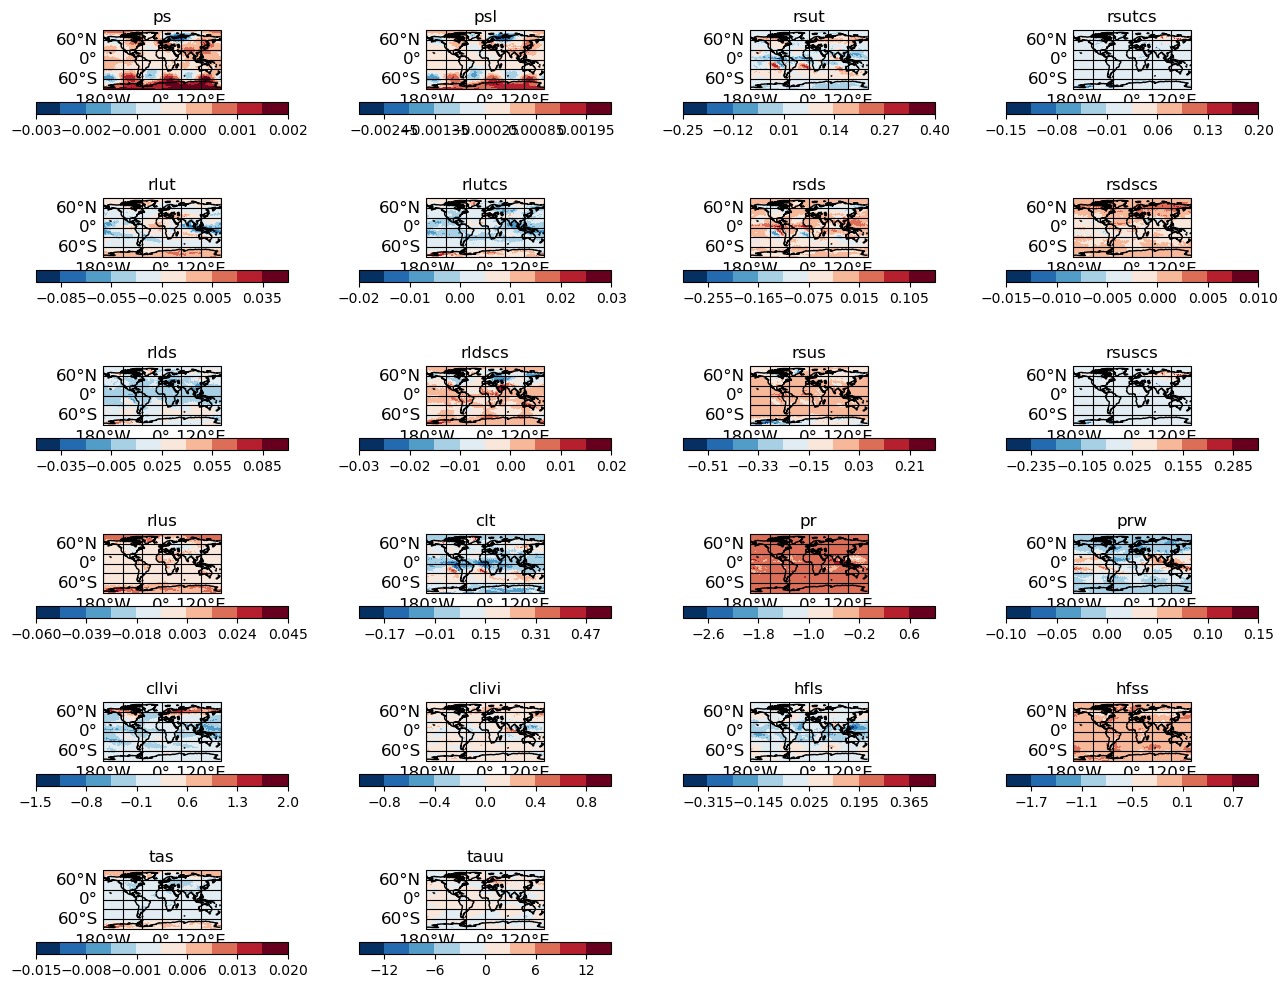

In [84]:
# Variables to loop through
all_vars = list(rel_diffs_4K.keys())
n_plots = len(all_vars)

plt.figure(figsize=(20, 25))

# Define subplots 
ax = list(psy.multiple_subplots(rows=n_plots//4 + 1, cols=4, n=n_plots-1, for_maps=True))

plot_ind = 0
for var in all_vars:
    if var == 'rsdt': # Is all 0
        continue
    file_template.clt.values[0] = rel_diffs_4K[var].values
    psy.plot.mapplot(file_template, name='clt', title=var, time = [0], ax = ax[plot_ind], cmap='RdBu_r')
    plot_ind = plot_ind + 1

plt.subplots_adjust(hspace=1, wspace=0.2)

##### Focusing in on the largest relative differences

<Figure size 1000x1000 with 0 Axes>

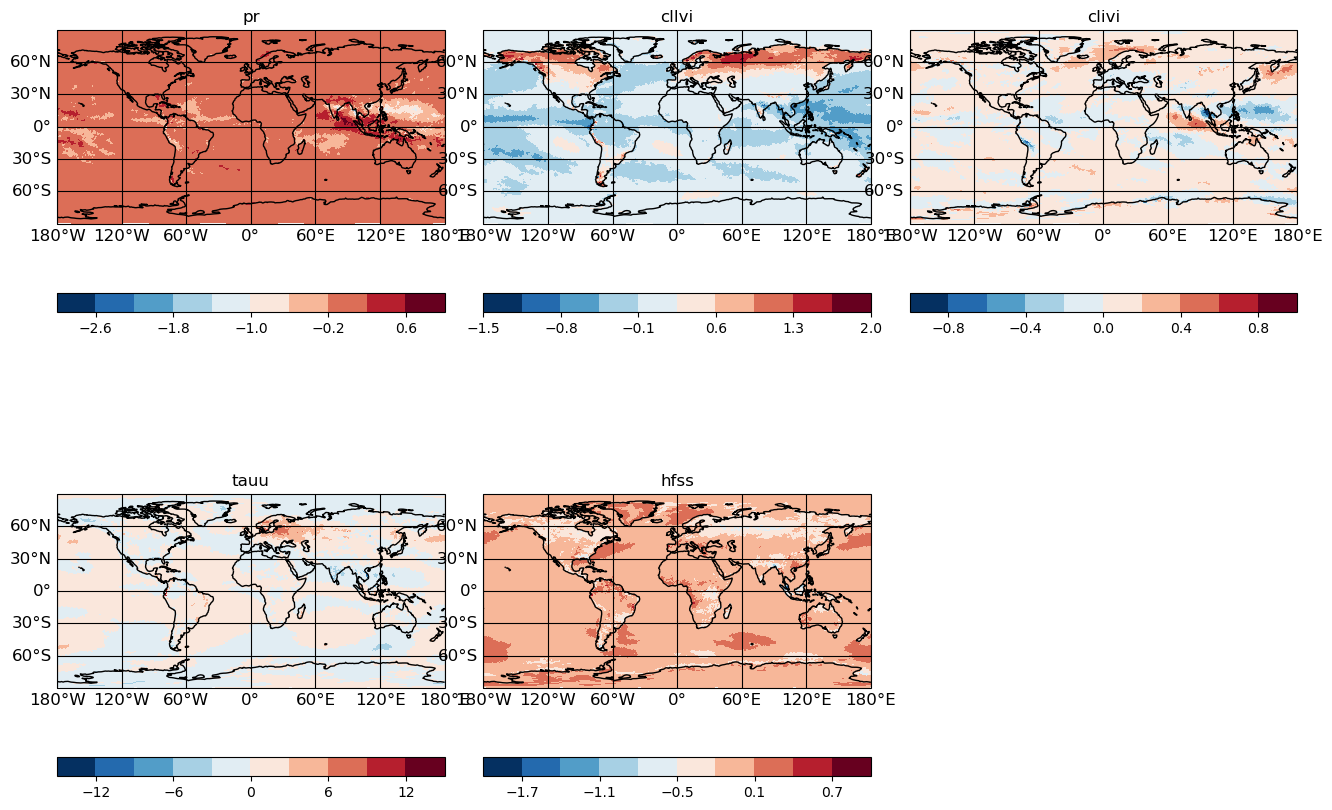

In [90]:
# Variables to loop through
all_vars = list(rel_diffs_4K.keys())
n_plots = len(all_vars)

plt.figure(figsize=(10, 10))

# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=3, n=5, for_maps=True))

plot_ind = 0
for var in ['pr', 'cllvi', 'clivi', 'tauu', 'hfss']:
    if var == 'rsdt': # Is all 0
        continue
    file_template.clt.values[0] = rel_diffs_4K[var].values
    psy.plot.mapplot(file_template, name='clt', title=var, time = [0], ax = ax[plot_ind], cmap='RdBu_r')
    plot_ind = plot_ind + 1

plt.subplots_adjust(hspace=0.01, wspace=0.1)

In [ ]:
# Variables to loop through
all_vars = list(rel_diffs_4K.keys())
n_plots = len(all_vars)

plt.figure(figsize=(10, 10))

# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=3, n=5, for_maps=True))

plot_ind = 0
for var in ['pr', 'cllvi', 'clivi', 'tauu', 'hfss']:
    if var == 'rsdt': # Is all 0
        continue
    file_template.clt.values[0] = rel_diffs_4K[var].values
    psy.plot.mapplot(file_template, name='clt', title=var, time = [0], ax = ax[plot_ind], cmap='RdBu_r')
    plot_ind = plot_ind + 1

plt.subplots_adjust(hspace=0.01, wspace=0.1)

#### Bias plots of ICON-ML vs ICON-A of different variables
Variables considered so far: clt, pr, swcre, lwcre

**First we need to get the numbers from the esmvaltool evaluation runs**

Ran with clouds environment

In [214]:
%%bash

# Download required files

module load py-python-swiftclient
module switch py-python-swiftclient/3.12.0-gcc-11.2.0

cd /home/b/b309170/bd1179_work/esmvaltool_output/from_swiftbrowser

# clt map OBS
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_top_right.nc
# clt map tuned ICON-ML bias
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc
# clt map ICON-A bias
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_clt/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_clt_ICON_Amon_bottom.nc

# pr map OBS
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_basics_maps_20240930_134550/work/maps_pr/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_top_right.nc
# pr map tuned ICON-ML bias
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_basics_maps_20240930_134550/work/maps_pr/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_bottom.nc
# pr map ICON-A bias
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_basics_maps_20240930_133811/work/maps_pr/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_pr_ICON_Amon_bottom.nc

# swcre map OBS
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_swcre/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_top_right.nc
# swcre map tuned ICON-ML bias
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_swcre/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_bottom.nc
# swcre map ICON-A bias
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_swcre/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_swcre_ICON_Amon_bottom.nc

# lwcre map OBS
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_lwcre/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_lwcre_ICON_Amon_top_right.nc
# lwcre map tuned ICON-ML
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_lwcre/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_lwcre_ICON_Amon_top_left.nc
# lwcre map ICON-A
swift download iconeval ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_lwcre/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_lwcre_ICON_Amon_top_left.nc

ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_top_right.nc [auth 0.000s, headers 0.109s, total 0.174s, 0.491 MB/s]
ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc [auth 0.000s, headers 0.092s, total 0.123s, 0.741 MB/s]
ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_clt/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_clt_ICON_Amon_bottom.nc [auth 0.000s, headers 0.065s, total 0.099s, 0.922 MB/s]
ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_basics_maps_20240930_134550/work/maps_pr/plot/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240

Your swift token will expire on Fri 01. Nov 16:07:18 CEST 2024
Your swift token will expire on Fri 01. Nov 16:07:18 CEST 2024


##### Cloud Cover

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


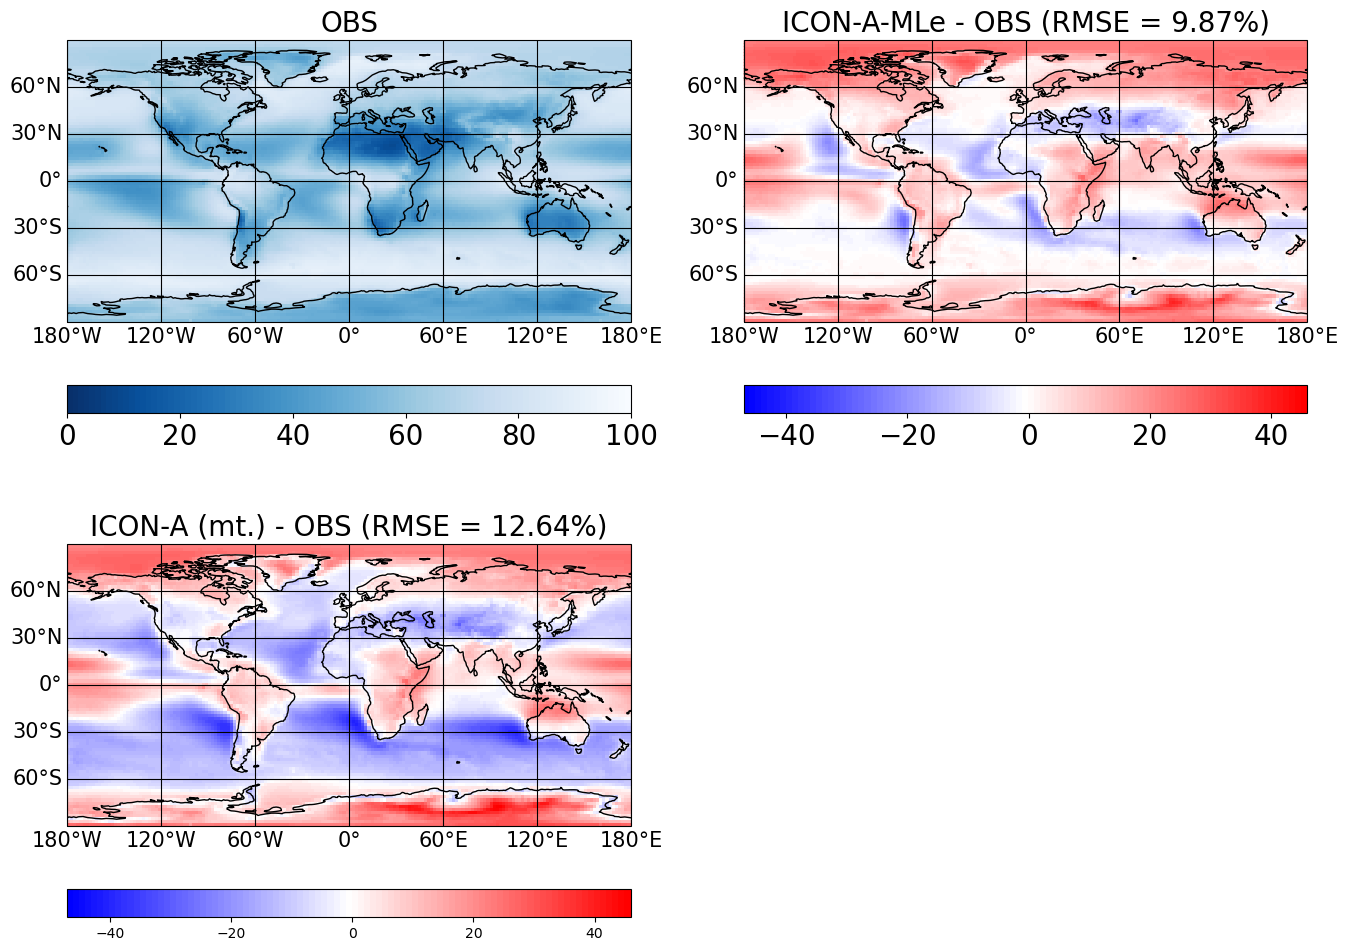

In [ ]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_top_right.nc'%path, ax = ax[plot_ind],
                        name='clt', title='OBS', cmap='Blues_r', bounds = np.arange(0,100.1), cticks=np.arange(0, 100.1, 20), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path)
        # From https://swiftbrowser.dkrz.de/objects/iconeval/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/plots/maps_clt/plot/
        rmse = 9.87 # Be careful NOT to take the sqrt_mean here as the data is in latlon (180/90)
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A-MLe - OBS (RMSE = %.2f%s)'%(rmse, '%%'), cmap='bwr', cticksize=20, bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Manually tuned ICON-A
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_clt/plot'%base_path
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_clt_ICON_Amon_bottom.nc'%path)
        # From https://swiftbrowser.dkrz.de/objects/iconeval/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/plots/maps_clt/plot/
        rmse = 12.64 # Be careful NOT to take the sqrt_mean here as the data is in latlon (180/90)
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_clt_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A (mt.) - OBS (RMSE = %.2f%s)'%(rmse, '%%'), cmap='bwr', bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), titlesize=20, grid_labelsize=15)


##### Cloud Cover Bias Plot Differences

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


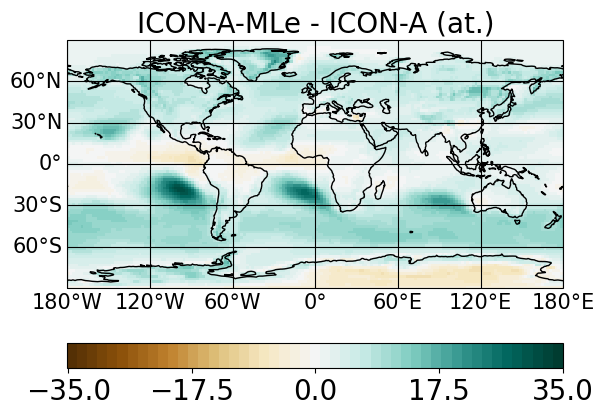

In [3]:
# Tuned ICON-ML
path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
data_ml = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path)
# Automatically tuned ICON-A
path = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_20241202_141113UTC/esmvaltool_output/recipe_clouds_maps_20241202_141300/work/maps_clt/plot'
data_a = xr.open_dataset('%s/map_ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_clt_ICON_Amon_bottom.nc'%path)

data_a.unknown.values = data_ml.unknown.values - data_a.unknown.values

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "lat_bnds", "lon_bnds"]
data_a = data_a.set_coords([coord for coord in data_a.data_vars if coord in coordlist])

psy.plot.mapplot(data_a, title='ICON-A-MLe - ICON-A (at.)', name='unknown', cticksize=20, titlesize=20, grid_labelsize=15, bounds=np.linspace(-35.1, 35.1, 50) \
                 , cticks=np.linspace(-35, 35, 5), cmap='BrBG')

cbar = plt.gcf().axes[-1]
cbar.tick_params(which='minor', bottom=False, left=False)

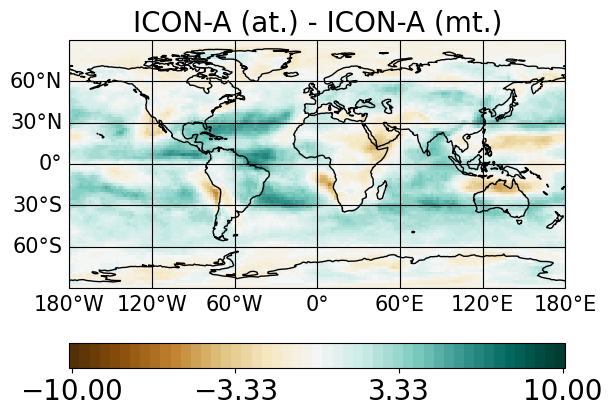

In [19]:
# Automatically tuned ICON-A
path = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_20241202_141113UTC/esmvaltool_output/recipe_clouds_maps_20241202_141300/work/maps_clt/plot'
data_a_at = xr.open_dataset('%s/map_ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_clt_ICON_Amon_bottom.nc'%path)
# Manually tuned ICON-A
path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_clt/plot'%base_path
data_a_mt = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_clt_ICON_Amon_bottom.nc'%path)

data_a_at.unknown.values = data_a_at.unknown.values - data_a_mt.unknown.values

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "lat_bnds", "lon_bnds"]
data_a_at = data_a_at.set_coords([coord for coord in data_a_at.data_vars if coord in coordlist])

psy.plot.mapplot(data_a_at, title='ICON-A (at.) - ICON-A (mt.)', name='unknown', cticksize=20, titlesize=20, grid_labelsize=15, bounds=np.linspace(-10.1, 10.1, 50), \
                 cticks=np.linspace(-10, 10, 4), cmap='BrBG')

cbar = plt.gcf().axes[-1]
cbar.tick_params(which='minor', bottom=False, left=False)

In [65]:
# compute rmses
path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path)
rmse = np.sqrt(np.mean(data.unknown**2))
print('ICON-ML: %.4f'%np.sqrt(np.mean(data.unknown**2)))

path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_clt/plot'%base_path
data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_clt_ICON_Amon_bottom.nc'%path)
rmse = np.sqrt(np.mean(data.unknown**2))
print('ICON-A: %.4f'%np.sqrt(np.mean(data.unknown**2)))

ICON-ML: 12.3010
ICON-A: 13.9126


##### SWCRE

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


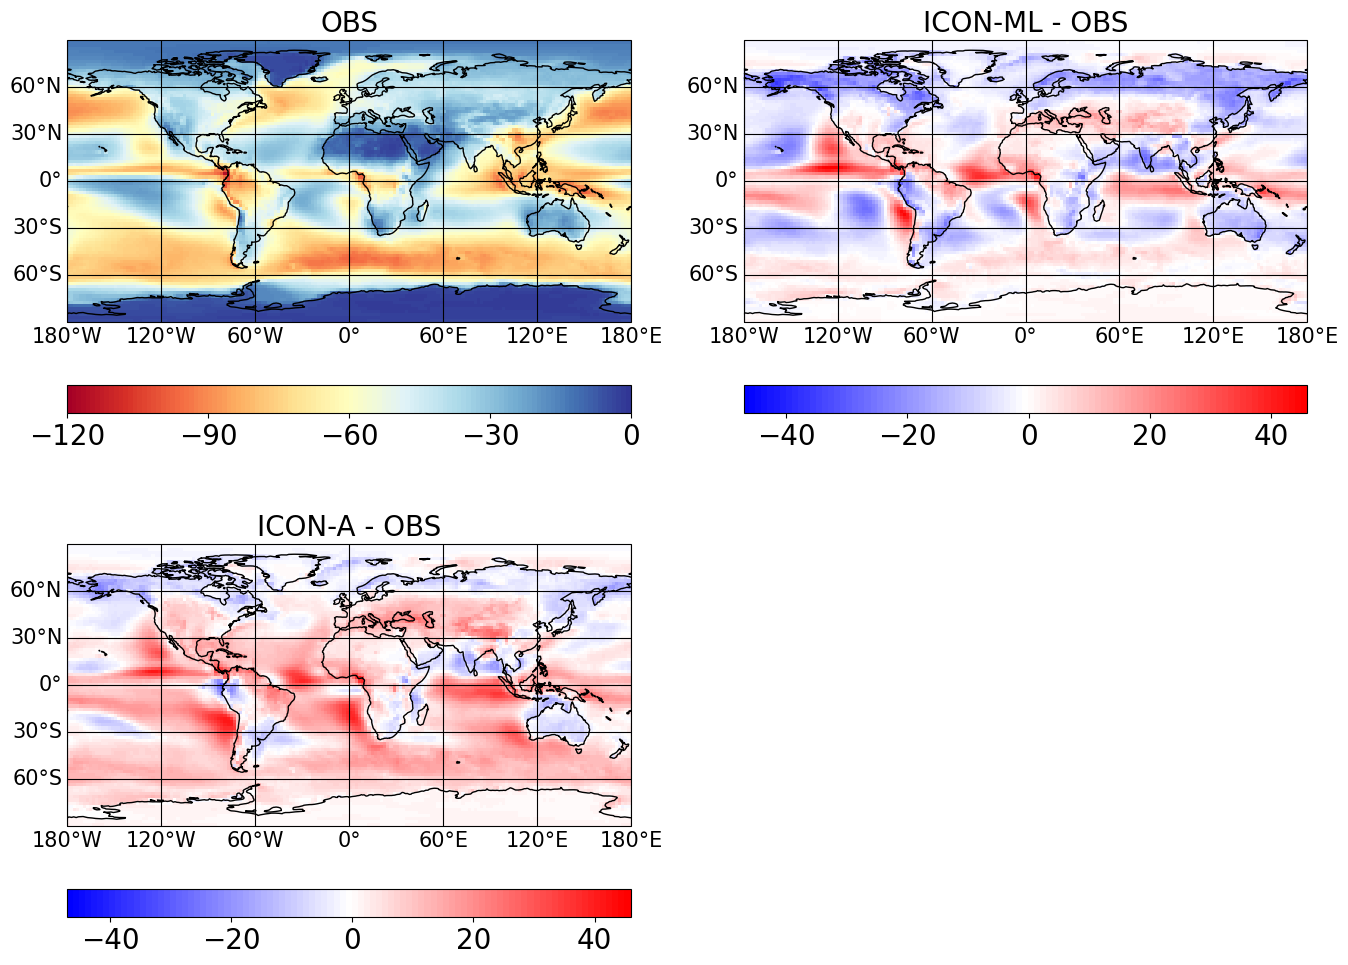

In [139]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_swcre/plot'%base_path
        ds = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_top_right.nc'%path)
        vmin = int(ds.swcre.min()) - 1 # 116
        vmax = int(ds.swcre.max()) + 1 # 0 
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_top_right.nc'%path, ax = ax[plot_ind],
                        name='swcre', title='OBS', cmap='RdYlBu', bounds = np.arange(-120,0.01), cticks=np.arange(-120,0.01, 30), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_swcre/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-ML - OBS', cmap='bwr', bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), cticksize=20,titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Tuned ICON-A
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_swcre/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_swcre_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A - OBS', cmap='bwr', bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), cticksize=20, titlesize=20, grid_labelsize=15)


**LWCRE**

Have to be careful to exclude ERA5

In [ ]:
float(ds.rlut.max())

In [207]:
ds = xr.open_dataset('/work/bd1179/b309170/from_esmvaltool/OBS_lwcre_mean_sign.nc')

In [ ]:
# Compute the reference OBS LWCRE first (from lwcre: ESACCI-CLOUD (19970101/20161231))

# # Moderate quality data, high resolution
# esacci_rlut = xr.open_mfdataset('/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ESACCI-CLOUD/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rlut_198201-201612.nc')
# esacci_rlutcs = xr.open_mfdataset('/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ESACCI-CLOUD/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rlutcs_198201-201612.nc')
# esacci_lwcre = esacci_rlutcs.rlutcs - esacci_rlut.rlut

In [ ]:
path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_lwcre/plot'%base_path
'%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_lwcre_ICON_Amon_top_left.nc'%path

In [ ]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        psy.plot.mapplot('/work/bd1179/b309170/from_esmvaltool/OBS_lwcre_mean_sign.nc', ax = ax[plot_ind],
                        name='rlut', title='OBS', cmap='Reds', bounds = np.arange(2, 74, 1), cticks=np.arange(2, 74.01, 10), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        psy.plot.mapplot('/work/bd1179/b309170/from_esmvaltool/ICON_ML-OBS.nc', ax = ax[plot_ind],
                        name='unknown', title='ICON-ML - OBS', cmap='bwr', cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Tuned ICON-A
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_lwcre/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_lwcre_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A - OBS', cmap='bwr', cticksize=20, titlesize=20, grid_labelsize=15)


##### Precipitation

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


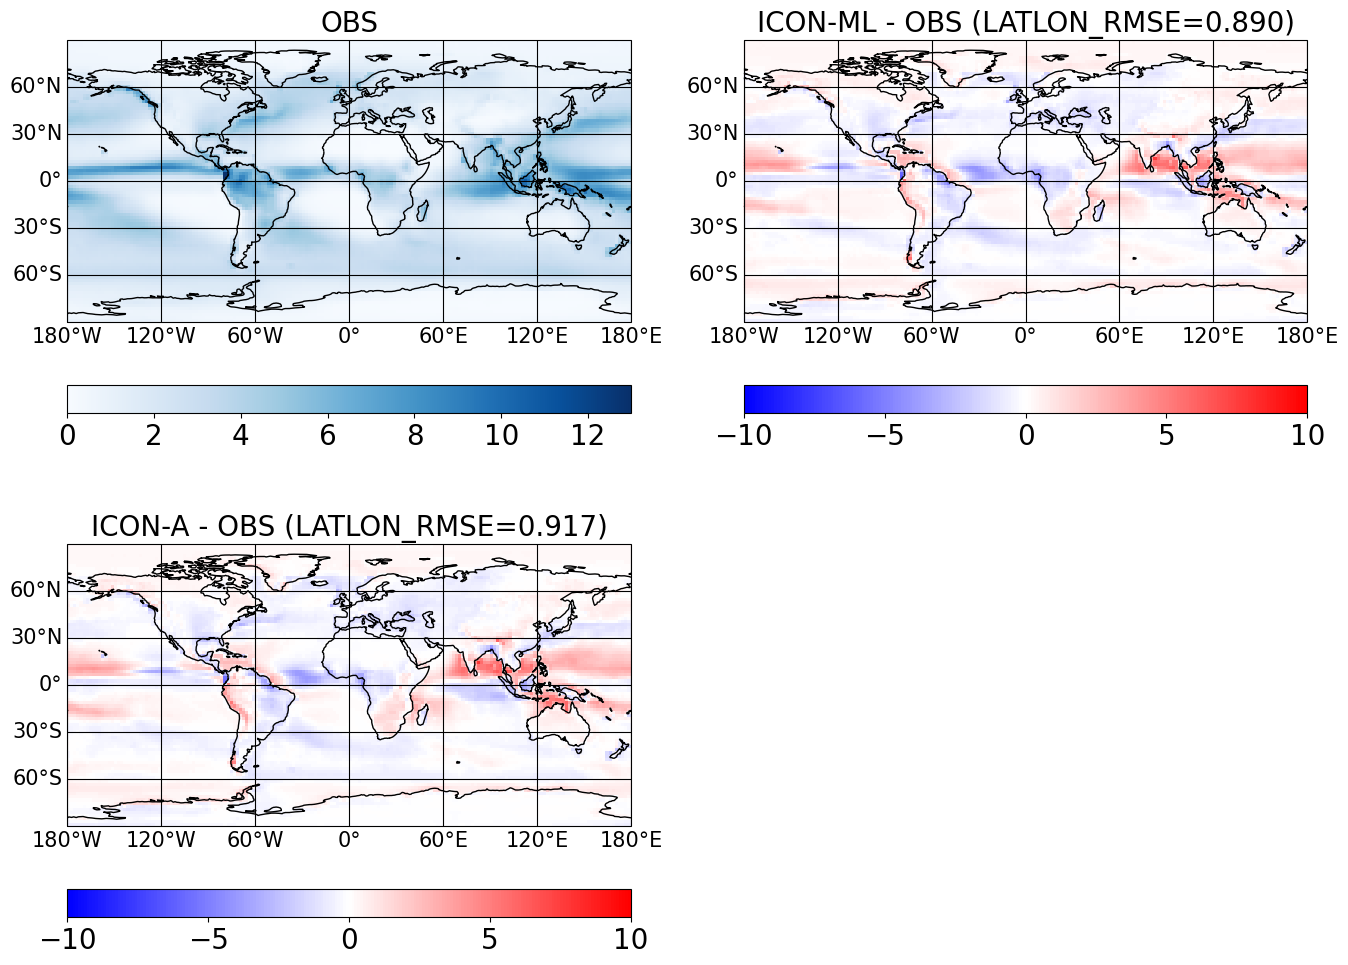

In [13]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_basics_maps_20240930_134550/work/maps_pr/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_top_right.nc'%path, ax = ax[plot_ind],
                        name='pr', title='OBS', cmap='Blues', bounds = np.arange(0, 13, 0.01), cticks=np.arange(0, 13, 2), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_basics_maps_20240930_134550/work/maps_pr/plot'%base_path
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_bottom.nc'%path)
        rmse = np.sqrt(np.mean(data.unknown**2))
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-ML - OBS (LATLON_RMSE=%.3f)'%rmse, cmap='bwr', bounds = np.arange(-10, 10.01, 0.1), cticks=np.arange(-10, 10.01, 5), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Tuned ICON-A
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_basics_maps_20240930_133811/work/maps_pr/plot'%base_path
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_pr_ICON_Amon_bottom.nc'%path)
        rmse = np.sqrt(np.mean(data.unknown**2))
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_pr_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A - OBS (LATLON_RMSE=%.3f)'%rmse, cmap='bwr', bounds = np.arange(-10, 10.01, 0.1), cticks=np.arange(-10, 10.01, 5), cticksize=20, titlesize=20, grid_labelsize=15)

##### Precipitation - South East Asian summer monsoon

Focus on 60E – 120E, 20S – 30N. In the NH, the summer and winter are defined as May–June-July-August-September (MJJAS) and November–December-January-February-March 

In [57]:
# TURN THIS INTO A METHOD - CALCULATE FOR ICON-A, ICON-ML, GPCP OBS

# Define spatial bounds
latitude_bounds = slice(-20, 30)  # Latitude from 20°S to 30°N
longitude_bounds = slice(60, 120)  # Longitude from 60°E to 120°E

# Define months for NH and SH summers
nh_summer_months = [5, 6, 7, 8, 9]  # May to September
sh_summer_months = [11, 12, 1, 2, 3]  # November to March

# Select region
regional_data = data_2d['icon_ml'].pr.where(
    (data_2d['icon_ml'].clat >= -20) & (data_2d['icon_ml'].clat <= 30) &
    (data_2d['icon_ml'].clon >= 60) & (data_2d['icon_ml'].clon <= 120),
    drop=True
)

# Separate data for NH and SH based on latitude. Use .where() to filter based on clat coordinate values from 0 to 30
nh_data = regional_data.where((regional_data.clat >= 0) & (regional_data.clat <= 30), drop=True)
sh_data = regional_data.where((regional_data.clat >= -20) & (regional_data.clat <= 0), drop=True)

# Convert time dimension to datetime format if it's not already
nh_data['time'] = xr.cftime_range(start='1979-01-01', end='1999-01-01', freq='MS')
sh_data['time'] = xr.cftime_range(start='1979-01-01', end='1999-01-01', freq='MS')

# Define NH and SH summer months
nh_summer_months = [5, 6, 7, 8, 9]      # May to September
sh_summer_months = [11, 12, 1, 2, 3]    # November to March

# Select only summer months using .where() and .dt.month accessor
nh_summer = nh_data.where(nh_data['time.month'].isin(nh_summer_months), drop=True)
sh_summer = sh_data.where(sh_data['time.month'].isin(sh_summer_months), drop=True)

# Filter for NH summer months and calculate mean
nh_summer_avg = nh_summer.mean(dim='time')

# Filter for SH summer months and calculate mean
sh_summer_avg = sh_summer.mean(dim='time')

In [58]:
nh_summer_avg

<xarray.DataArray 'pr' (ncells: 0)>
dask.array<mean_agg-aggregate, shape=(0,), dtype=float32, chunksize=(0,), chunktype=numpy.ndarray>
Coordinates:
    clon     (ncells) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(0,), meta=np.ndarray>
Dimensions without coordinates: ncells

In [17]:
# OBS from GPCP-SG
data_2d['icon_ml'].pr

<xarray.DataArray 'pr' (time: 241, ncells: 81920)>
dask.array<concatenate, shape=(241, 81920), dtype=float32, chunksize=(12, 81920), chunktype=numpy.ndarray>
Coordinates:
    clon     (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
  * time     (time) float64 1.979e+07 1.979e+07 ... 1.998e+07 1.999e+07
Dimensions without coordinates: ncells
Attributes:
    standard_name:                pr
    long_name:                    precipitation flux
    units:                        kg m-2 s-1
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

##### LW Radiation

In [6]:
import subprocess

def remap_esacci_var(var_name):
    ## Remaps ESACCI data and returns the remapped dataset

    # Have rsdt, rlutcs, rsut, rlut, rsutcs, clivi, rlus, cltStderr, rsus, clwvi, clt, rsuscs, lwp at our disposition    
    esacci_rad_file="/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ESACCI-CLOUD/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612.nc"%var_name
    some_iconml_file="/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_atm_2d_ml_19810101T000000Z.nc"
    target_file_esacci="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612_r2b5.nc"%var_name
    target_file_int="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612_r2b5_int.nc"%var_name
    target_file_int2="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612_r2b5_int2.nc"%var_name

    subprocess.run('module load cdo', check=True, shell=True)
    subprocess.run(['cdo','seltimestep,1/216', esacci_rad_file, target_file_int2], check=True) # Select proper timerange (up to and including 2000)
    subprocess.run(['cdo','timmean', target_file_int2, target_file_int], check=True)
    subprocess.run(['cdo', 'remapcon,' + some_iconml_file, target_file_int, target_file_esacci], check=True)
    subprocess.run(['rm', target_file_int], check=True)
    subprocess.run(['rm', target_file_int2], check=True)

    # Load preprocessed OBS data
    obs_rad = getattr(xr.open_dataset(target_file_esacci), var_name)[0]

    return obs_rad

def remap_isccp_var(var_name):
    ## Remaps ISCCP rad. data and returns the remapped dataset

    # Have rlut, rsut, alb, prw, ps, rsutcs, rlutcs, rsdt, rsds, rlus, rlds at our disposition    
    isccp_rad_file="/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ISCCP-FH/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612.nc"%var_name
    some_iconml_file="/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_atm_2d_ml_19810101T000000Z.nc"
    target_file_isccp="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612_r2b5.nc"%var_name
    target_file_int="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612_r2b5_int.nc"%var_name
    target_file_int2="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612_r2b5_int2.nc"%var_name

    subprocess.run('module load cdo', check=True, shell=True)
    subprocess.run(['cdo','seltimestep,1/196', isccp_rad_file, target_file_int2], check=True) # Select proper timerange (up to and including 2000)
    subprocess.run(['cdo','timmean', target_file_int2, target_file_int], check=True)
    subprocess.run(['cdo', 'remapcon,' + some_iconml_file, target_file_int, target_file_isccp], check=True)
    subprocess.run(['rm', target_file_int], check=True)
    subprocess.run(['rm', target_file_int2], check=True)

    # Load preprocessed OBS data
    obs_rad = getattr(xr.open_dataset(target_file_isccp), var_name)[0]

    return obs_rad

def preprocess_obs(var_name = 'rlut'):
    '''
        Get observations for radiation.
    '''
    ## OBS data. Load preprocessed OBS data
    if var_name in ['rlut', 'rsut']: # ESACCI + ISCCP as OBS
        obs_rad1 = remap_esacci_var(var_name)
        obs_rad2 = remap_isccp_var(var_name)
    elif var_name == 'lwcre':
        # ESACCI
        rlutcs = remap_esacci_var('rlutcs')
        rlut = remap_esacci_var('rlut')
        obs_rad1 = rlutcs - rlut
        # ISCCP
        rlutcs = remap_isccp_var('rlutcs')
        rlut = remap_isccp_var('rlut')
        obs_rad2 = rlutcs - rlut
    elif var_name ==  'swcre':
        # ESACCI
        rsutcs = remap_esacci_var('rsutcs')
        rsut = remap_esacci_var('rsut')
        obs_rad1 = rsutcs - rsut
        # ISCCP
        rsutcs = remap_isccp_var('rsutcs')
        rsut = remap_isccp_var('rsut')
        obs_rad2 = rsutcs - rsut
    elif var_name in ['clivi', 'lwp']: # Only consider ESACCI as OBS
        obs_rad1 = remap_esacci_var(var_name)
        obs_rad2 = obs_rad1 
    return (obs_rad1 + obs_rad2)/2

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr11: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

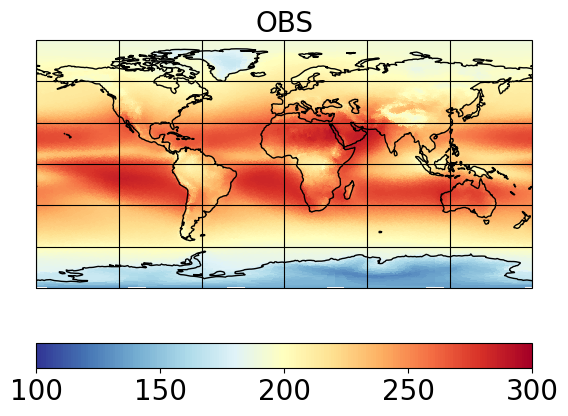

In [25]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rlut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rlut_198201-201612_r2b5.nc").rlut[0] 

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, bounds = np.arange(100, 300.1), cticks=np.arange(100, 300.1, 50), titlesize=20, grid_labelsize=15, cticksize=20)

In [12]:
float(np.min(icona_rlut_data_avrg - obs_avrg))

-25.346267700195312

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
RMSE = 9.0874


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr3: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

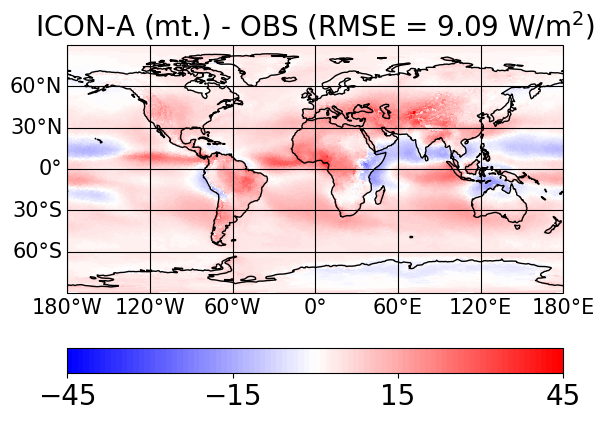

In [8]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rlut')

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/'

icona_rlut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlut[1:]
icona_rlut_data_avrg = icona_rlut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_rlut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A (mt.) - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = np.arange(-45, 45.01), cticks=np.arange(-45, 45.01, 30), titlesize=20, grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
RMSE = 8.3448


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr9: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

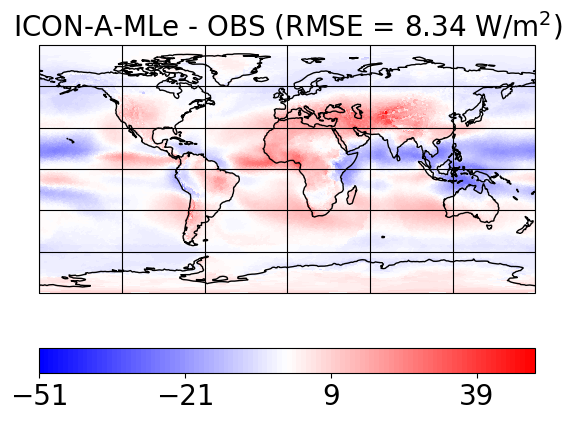

In [ ]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rlut')

# Load ICON-ML data
data_path = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long/'

iconml_rlut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlut[1:]
iconml_rlut_data_avrg = iconml_rlut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_rlut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A-MLe - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = np.arange(-51, 51.01), \
                  cticks=np.arange(-51, 51.01, 30), grid_labels=0, titlesize=20, grid_labelsize=15, cticksize=20)

##### LW Bias Plot Differences

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


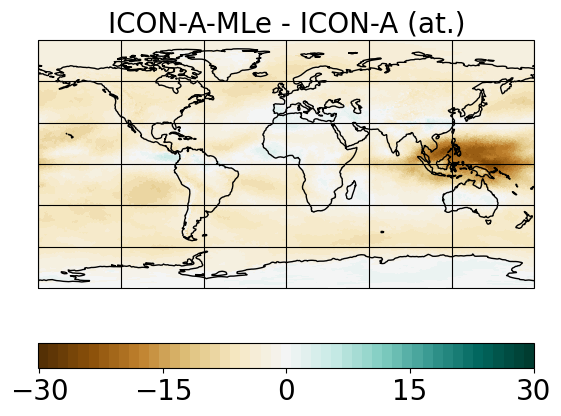

In [7]:
# Load ICON-ML data
data_path_ml = paths['icon_ml']
iconml_rlut_data_ml = xr.open_mfdataset(data_path_ml + '/*atm_2d_ml*.nc').rlut[1:]
iconml_rlut_data_avrg_ml = iconml_rlut_data_ml.mean('time')

# Load ICON-A (at.) data
data_path_at = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/' # ICON-A (at.)
iconml_rlut_data_at = xr.open_mfdataset(data_path_at + '/*atm_2d_ml*.nc').rlut[1:]
iconml_rlut_data_avrg_at = iconml_rlut_data_at.mean('time')

# Load ICON-A (mt.) data
data_path_mt = paths['icon_nat'] # ICON-A (mt.)
iconml_rlut_data_mt = xr.open_mfdataset(data_path_mt + '/*atm_2d_ml*.nc').rlut[1:]
iconml_rlut_data_avrg_mt = iconml_rlut_data_mt.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_rlut_data_avrg_ml - iconml_rlut_data_avrg_at
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A-MLe - ICON-A (at.)', cmap='BrBG', grid_labels=0, bounds=np.linspace(-30.1, 30.1, 50), \
                 cticks=np.linspace(-30, 30, 5), titlesize=20, grid_labelsize=15, cticksize=20)

cbar = plt.gcf().axes[-1]
cbar.tick_params(which='minor', bottom=False, left=False)

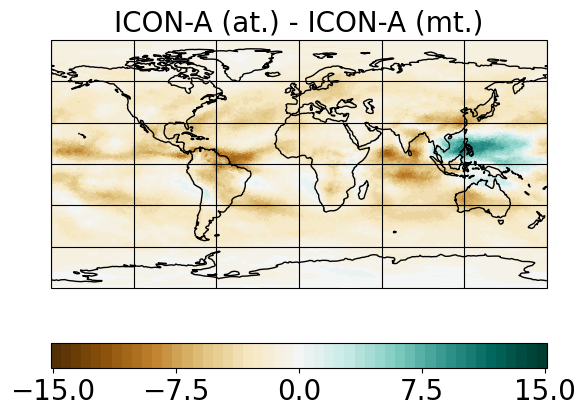

In [15]:
# Plot LW radiation
file_template.clt.values[0] = iconml_rlut_data_avrg_at - iconml_rlut_data_avrg_mt
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A (at.) - ICON-A (mt.)', cmap='BrBG', grid_labels=0, titlesize=20, bounds=np.linspace(-15.1, 15.1, 50), \
                 cticks=np.linspace(-15, 15, 5), grid_labelsize=15, cticksize=20)

cbar = plt.gcf().axes[-1]
cbar.tick_params(which='minor', bottom=False, left=False)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
RMSE = 7.5694


psyplot.project.Project([    arr15: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

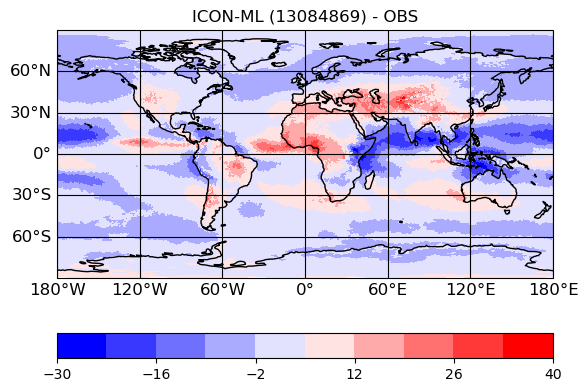

In [19]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rlut')

# Load ICON-ML data
data_path = '/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_13084869_20yrs_241002/'

iconml_rlut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlut[1:]
iconml_rlut_data_avrg = iconml_rlut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_rlut_data_avrg - obs_avrg
print('RMSE = %.4f'%np.sqrt(np.mean((file_template.clt.values[0])**2)))
psy.plot.mapplot(file_template, name='clt', time = [0], title='ICON-ML (13084869) - OBS', cmap='bwr')

##### SW Radiation

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr40: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

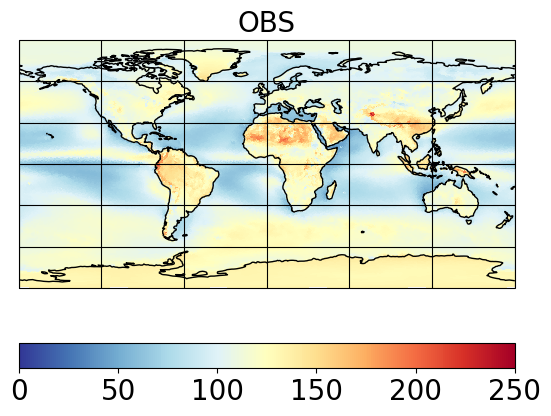

In [42]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rsut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rsut_198201-201612_r2b5.nc").rsut[0] 

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, titlesize=20, bounds = np.arange(0, 250.01), \
                  cticks=np.arange(0, 250.01, 50), grid_labelsize=15, cticksize=20)

RMSE = 13.8353


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr28: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

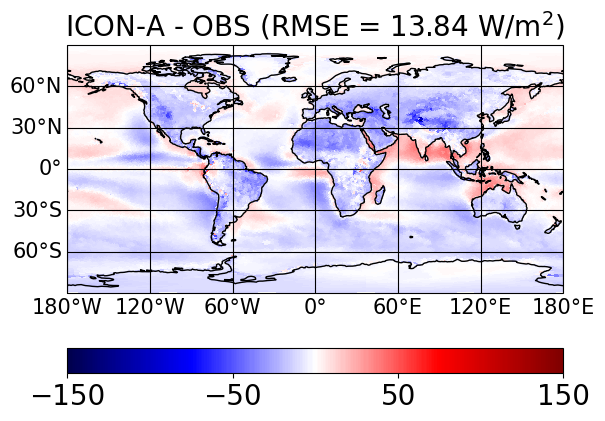

In [ ]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rsut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rsut_198201-201612_r2b5.nc").rsut[0] 

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/'

icona_rsut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[1:]
icona_rsut_data_avrg = icona_rsut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_rsut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A (mt.) - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='seismic',titlesize=20, \
                 bounds = np.arange(-150, 150.01), cticks=np.arange(-150, 150.01, 100), grid_labelsize=15, cticksize=20)

RMSE = 12.9035


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr29: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

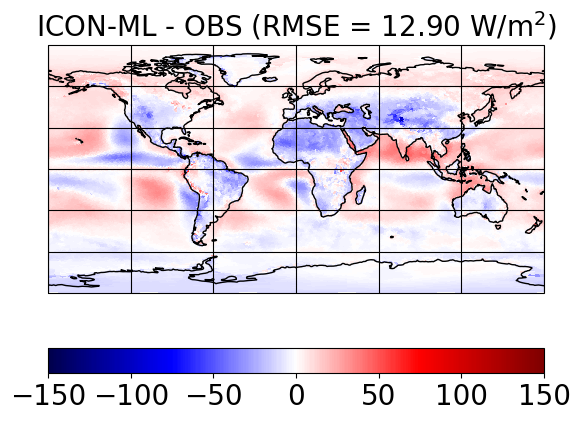

In [25]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rsut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rsut_198201-201612_r2b5.nc").rsut[0] 

# Load ICON data
data_path = '/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/'

iconml_rsut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[1:]
iconml_rsut_data_avrg = iconml_rsut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot SW radiation
file_template.clt.values[0] = iconml_rsut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='seismic', grid_labels=0, titlesize=20, \
                  bounds = np.arange(-150, 150.01), cticks=np.arange(-150, 150.01, 50), grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
RMSE = 12.6198


psyplot.project.Project([    arr14: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

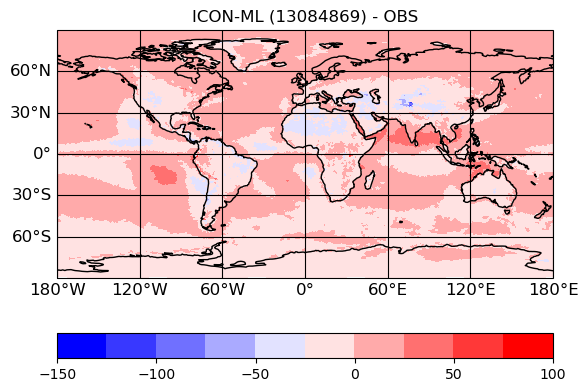

In [18]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rsut')

# Load ICON data
data_path = '/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_13084869_20yrs_241002/'

iconml_rsut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[1:]
iconml_rsut_data_avrg = iconml_rsut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot SW radiation
file_template.clt.values[0] = iconml_rsut_data_avrg - obs_avrg
print('RMSE = %.4f'%np.sqrt(np.mean((file_template.clt.values[0])**2)))
psy.plot.mapplot(file_template, name='clt', time = [0], title='ICON-ML (13084869) - OBS', cmap='bwr', grid_labels=None)

SW Bias plot differences

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


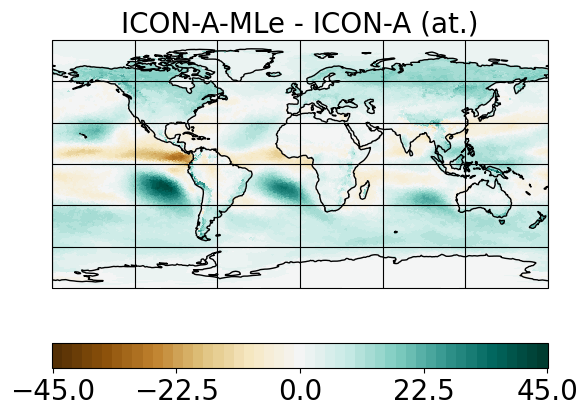

In [9]:
# Load ICON-ML data
data_path_ml = paths['icon_ml']
iconml_rsut_data_ml = xr.open_mfdataset(data_path_ml + '/*atm_2d_ml*.nc').rsut[1:]
iconml_rsut_data_avrg_ml = iconml_rsut_data_ml.mean('time')

# Load ICON-A (at.) data
data_path_at = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/' # ICON-A (at.)
iconml_rsut_data_at = xr.open_mfdataset(data_path_at + '/*atm_2d_ml*.nc').rsut[1:]
iconml_rsut_data_avrg_at = iconml_rsut_data_at.mean('time')

# Load ICON-A (mt.) data
data_path_mt = paths['icon_nat'] # ICON-A (mt.)
iconml_rsut_data_mt = xr.open_mfdataset(data_path_mt + '/*atm_2d_ml*.nc').rsut[1:]
iconml_rsut_data_avrg_mt = iconml_rsut_data_mt.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot SW radiation
file_template.clt.values[0] = iconml_rsut_data_avrg_ml - iconml_rsut_data_avrg_at
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A-MLe - ICON-A (at.)', cmap='BrBG', grid_labels=0, bounds=np.linspace(-45.1, 45.1, 50), \
                 cticks=np.linspace(-45, 45, 5), titlesize=20, grid_labelsize=15, cticksize=20)

cbar = plt.gcf().axes[-1]
cbar.tick_params(which='minor', bottom=False, left=False)

##### Cloud Ice

In [109]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('clivi')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, titlesize=20, bounds = np.arange(0, 0.17), \
                  cticks=np.arange(0, 0.17, 50), grid_labelsize=15, cticksize=20)

seltimestep,1/216: cdo: command not found


CalledProcessError: Command '['cdo', 'seltimestep,1/216', '/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ESACCI-CLOUD/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_clivi_198201-201612.nc', '/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_clivi_198201-201612_r2b5_int2.nc']' returned non-zero exit status 127.

RMSE = 13.8353


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr28: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

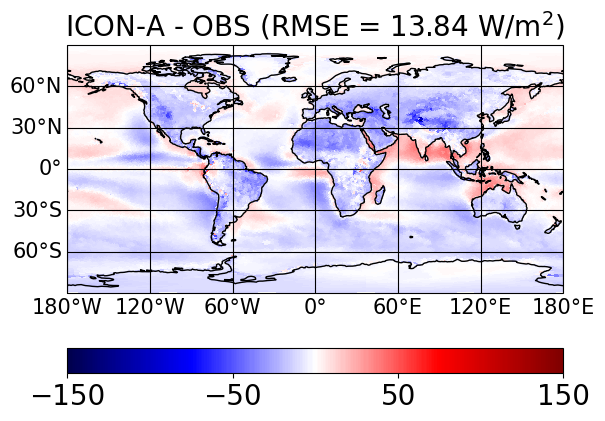

In [ ]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rsut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rsut_198201-201612_r2b5.nc").rsut[0] 

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/'

icona_rsut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[1:]
icona_rsut_data_avrg = icona_rsut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_rsut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='seismic',titlesize=20, \
                 bounds = np.arange(-150, 150.01), cticks=np.arange(-150, 150.01, 100), grid_labelsize=15, cticksize=20)

RMSE = 12.9035


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr29: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

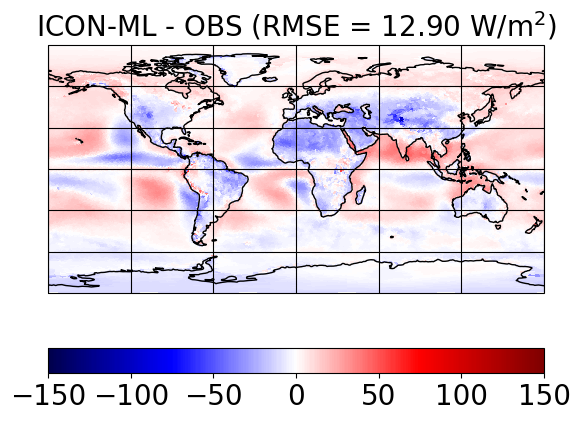

In [ ]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rsut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rsut_198201-201612_r2b5.nc").rsut[0] 

# Load ICON data
data_path = '/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/'

iconml_rsut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[1:]
iconml_rsut_data_avrg = iconml_rsut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot SW radiation
file_template.clt.values[0] = iconml_rsut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='seismic', grid_labels=0, titlesize=20, \
                  bounds = np.arange(-150, 150.01), cticks=np.arange(-150, 150.01, 50), grid_labelsize=15, cticksize=20)

#### Comparison of TOA balance between ICON-ML runs

We should stick to the old ICON-ML simulation (so based_on_12962670)

In [115]:
data_path1 = "/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_13084869_20yrs_241002/"
data_path2 = "/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/"

N = 1
M = -1

iconml1_rsut_data = xr.open_mfdataset(data_path1 + '*atm_2d_ml*.nc').rsut[N:]
iconml2_rsut_data = xr.open_mfdataset(data_path2 + '*atm_2d_ml*.nc').rsut[N:]

iconml1_rsdt_data = xr.open_mfdataset(data_path1 + '*atm_2d_ml*.nc').rsdt[N:]
iconml2_rsdt_data = xr.open_mfdataset(data_path2 + '*atm_2d_ml*.nc').rsdt[N:]

iconml1_rlut_data = xr.open_mfdataset(data_path1 + '*atm_2d_ml*.nc').rlut[N:]
iconml2_rlut_data = xr.open_mfdataset(data_path2 + '*atm_2d_ml*.nc').rlut[N:]


print('Old ICON-ML sim: %.3f'%float(np.mean(iconml2_rsdt_data - iconml2_rsut_data - iconml2_rlut_data)))
print('New ICON-ML sim: %.3f'%float(np.mean(iconml1_rsdt_data - iconml1_rsut_data - iconml1_rlut_data)))

Old ICON-ML sim: 0.178
New ICON-ML sim: -0.229
